In [1]:
import os
import gzip
import pandas as pd
import numpy as np
import re

ROOT = "/group/iorio/lucia/"
FOLD_PROJECT = os.path.join(ROOT, "Multiomic_VAE/")

xena_folder = os.path.join(ROOT, "datasets/XENA/TCGA_TARGET_GTEx/")
xena_gene_file = os.path.join(xena_folder, "TcgaTargetGtex_rsem_gene_tpm")
# xena_gene_file = os.path.join(xena_folder, "TEST_rsem_gene_tpm")
xena_gene_mapping_file = os.path.join(xena_folder, 'probeMap%2Fgencode.v23.annotation.gene.probemap')
xena_sample_file = os.path.join(xena_folder, 'TcgaTargetGTEX_phenotype.txt.gz')

depmap_folder = os.path.join(ROOT, "datasets/DEPMAP_PORTAL/version_23Q2/")
depmap_gene_file = os.path.join(depmap_folder, "OmicsExpressionProteinCodingGenesTPMLogp1.csv")
depmap_sample_file = os.path.join(depmap_folder, "Model.csv")

# gene annotation
hgnc_gene_ann_file = os.path.join(ROOT, "datasets/hgnc_complete_set_202311.txt")
hgnc_gene_ann_df = pd.read_csv(hgnc_gene_ann_file, sep="\t", low_memory=False)

# load depmap data
depmap_gene_df = pd.read_csv(depmap_gene_file, sep=',', index_col=0)
depmap_gene_df.index.name = 'sample_id'
depmap_sample_df = pd.read_csv(depmap_sample_file, sep=',', index_col=0)
depmap_sample_df.index.name = 'sample_id'

# load tissue data
with gzip.open(xena_sample_file) as f:
    xena_sample_df = pd.read_csv(f, sep='\t', index_col=0, encoding='ISO-8859-1')
xena_sample_df.index.name = 'sample_id'
xena_gene_mapping_df = pd.read_csv(xena_gene_mapping_file, sep='\t')

xena_gene_df = pd.read_csv(xena_gene_file, sep='\t')
xena_gene_df.index = xena_gene_df['sample']
xena_gene_df = xena_gene_df.drop(columns=['sample'])
xena_gene_df.index.name = 'xena_gene_id'


In [4]:
##################
### FUNCTIONS ####
##################

def generate_sankey_chart_data(df, columns, sankey_link_weight):
    # list of list: each list are the set of nodes in each tier/column
    column_values = [df[col] for col in columns]
    # this generates the labels for the sankey by taking all the unique values
    labels = sum([list(node_values.unique()) for node_values in column_values],[])
    # initializes a dict of dicts (one dict per tier) 
    link_mappings = {col: {} for col in columns}

    # each dict maps a node to unique number value (same node in different tiers
    # will have different nubmer values
    i = 0
    for col, nodes in zip(columns, column_values):
        for node in nodes.unique():
            link_mappings[col][node] = i
            i = i + 1
    # specifying which coluns are serving as sources and which as sources
    # ie: given 3 df columns (col1 is a source to col2, col2 is target to col1 and 
    # a source to col 3 and col3 is a target to col2
    source_nodes = column_values[: len(columns) - 1]
    target_nodes = column_values[1:]
    source_cols = columns[: len(columns) - 1]
    target_cols = columns[1:]
    links = []
    # loop to create a list of links in the format [((src,tgt),wt),(),()...]
    for source, target, source_col, target_col in zip(source_nodes, target_nodes, source_cols, target_cols):
        for val1, val2, link_weight in zip(source, target, df[sankey_link_weight]):
            links.append(((link_mappings[source_col][val1],link_mappings[target_col][val2]),link_weight,))

    # creating a dataframe with 2 columns: for the links (src, tgt) and weights
    df_links = pd.DataFrame(links, columns=["link", "weight"])

    # aggregating the same links into a single link (by weight)
    df_links = df_links.groupby(by=["link"], as_index=False).agg({"weight": sum})

    # generating three lists needed for the sankey visual
    sources = [val[0] for val in df_links["link"]]
    targets = [val[1] for val in df_links["link"]]
    weights = df_links["weight"]

    return labels, sources, targets, weights


# create a function to create standard deviation and mean per gene (colum)
def get_mean_std_cv(df):
    std = df.std(axis=0)
    mean = df.mean(axis=0)
    df_summ = pd.DataFrame({'id': df.columns, 'mean': mean, 'std': std})
    df_summ['cv'] =  df_summ['std'] /  df_summ['mean']
    # remove index
    df_summ = df_summ.reset_index(drop=True)
    return df_summ 

In [5]:
########################
### MATCH AND FILTER ###
########################

# match data frames by gene id (use hgnc annotation)
# to get the new gene names, assign to a dataframe and match with the two available annotations!
gene_names = []
gene_ids = []

# Split each element in the array and extract gene name and ID
for column_name in depmap_gene_df.columns:
    parts = re.split(r'\s*\(|\)\s*', column_name)
    gene_name = parts[0].strip()
    gene_id = parts[1].strip()
    gene_names.append(gene_name)
    gene_ids.append(gene_id)

# Create a DataFrame with the gene names and gene IDs as columns
df = pd.DataFrame({'gene_name': gene_names, 'entrez_id': gene_ids})

# match with hgnc
df['entrez_id'] = df['entrez_id'].astype('float64')
match_df = pd.merge(df, 
                    hgnc_gene_ann_df[["hgnc_id", "entrez_id", "symbol", "ensembl_gene_id"]], 
                    on = 'entrez_id')
# match with xena gene mapping
xena_gene_mapping_df['ensembl_gene_id'] = xena_gene_mapping_df['id'].str.split('.').str[0]
match_df = pd.merge(match_df, xena_gene_mapping_df, on = 'ensembl_gene_id')

# remvoe duplicates and modify names
match_df = match_df.drop_duplicates(subset=["ensembl_gene_id"])
match_df['depmap_gene_id'] = match_df['gene_name'] + " (" + match_df['entrez_id'].astype('int').astype('str') + ")"
match_df['xena_gene_id'] = match_df['id']
match_df['complete_id'] = match_df['symbol'] + " (" + match_df['ensembl_gene_id'] + ")"

# create a new data frame from depmap_gene_df, keep only those genes that have a value in depmap_id in match_df
depmap_gene_df_match = depmap_gene_df[match_df['depmap_gene_id']]
depmap_gene_df_match.columns = match_df['complete_id']
depmap_gene_df_match.columns.name = None

# create a new data frame from xena_gene_df, keep only those genes that have a value in xena_id in match_df
xena_gene_df_match = xena_gene_df.loc[match_df['xena_gene_id'], :]
# transpose xena_gene_df_match
xena_gene_df_match = xena_gene_df_match.transpose()
xena_gene_df_match.index.name = 'sample_id'
xena_gene_df_match.columns = match_df['complete_id']
xena_gene_df_match.columns.name = None
# convert entries in xena_gene_df_match: computed as log2(x+0.001) but should be log2(x+1)
xena_gene_df_match = np.log2(np.power(2, xena_gene_df_match) - 0.001 + 1)
xena_gene_df_match[xena_gene_df_match.abs() < 10**-7] = 0

# create final table (samples x genes)
tot_gene_df = pd.concat([depmap_gene_df_match, xena_gene_df_match], axis=0, sort=False)

In [12]:
print(xena_gene_df_match.shape)
print(depmap_gene_df_match.shape)

(19131, 19074)
(1450, 19074)


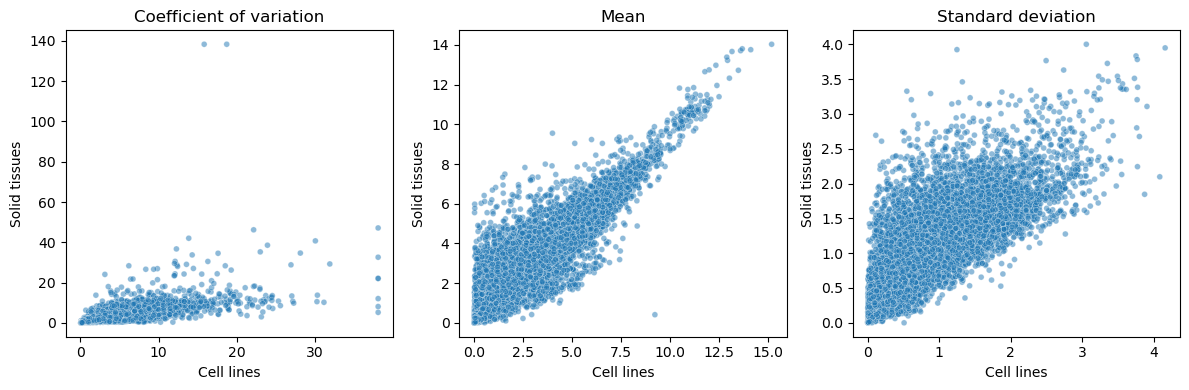

In [116]:
############
### PLOT ###
############

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# plot the distribution of the coefficient of variation
df_summary = pd.merge(
    get_mean_std_cv(depmap_gene_df_match), 
    get_mean_std_cv(xena_gene_df_match), 
    on = 'id', 
    suffixes=('_depmap', '_xena'))

# change the size of the plot
fig, axes = plt.subplots(1,3)
plt.rcParams['figure.figsize'] = [12, 4]

sns.scatterplot(data = df_summary, x = "cv_depmap", y = "cv_xena", size = 0.5, alpha = 0.5, ax = axes[0])
sns.scatterplot(data = df_summary, x = "mean_depmap", y = "mean_xena", size = 0.5, alpha = 0.5, ax = axes[1])
sns.scatterplot(data = df_summary, x = "std_depmap", y = "std_xena", size = 0.5, alpha = 0.5, ax = axes[2])
# change labels
axes[0].set_xlabel("Cell lines")
axes[0].set_ylabel("Solid tissues")
axes[1].set_xlabel("Cell lines")
axes[1].set_ylabel("Solid tissues")
axes[2].set_xlabel("Cell lines")
axes[2].set_ylabel("Solid tissues")
# remove legend
axes[0].get_legend().remove()
axes[1].get_legend().remove()
axes[2].get_legend().remove()
# title
axes[0].set_title("Coefficient of variation")
axes[1].set_title("Mean")
axes[2].set_title("Standard deviation")
plt.tight_layout()

plt.savefig(FOLD_PROJECT + "data_preprocessing/plot/GEX_compare_distributions.pdf", format = 'pdf')


In [14]:
# plot info on samples (solid tissues)
xena_samples = xena_sample_df.index.intersection(tot_gene_df.index)
xena_sample_df = xena_sample_df.loc[xena_samples]

vals_to_replace = {"Solid Tissue Normal": "Normal Tissue", 
                   "Primary Solid Tumor": "Primary Tumor", 
                   "Recurrent Solid Tumor": "Recurrent Tumor",
                   "Additional - New Primary": "Primary Tumor", 
                   "Additional Metastatic": "Metastatic", 
                   "Primary Blood Derived Cancer - Peripheral Blood": "Primary Blood Derived Cancer", 
                   "Primary Blood Derived Cancer - Bone Marrow": "Primary Blood Derived Cancer", 
                   "Recurrent Blood Derived Cancer - Bone Marrow": "Recurrent Blood Derived Cancer",
                   "Recurrent Blood Derived Cancer - Peripheral Blood": "Recurrent Blood Derived Cancer", 
                   "Post treatment Blood Cancer - Bone Marrow": "Post treatment Blood Cancer", 
                   "Post treatment Blood Cancer - Peripheral Blood": "Post treatment Blood Cancer", 
                   "Post treatment Blood Cancer - Blood": "Post treatment Blood Cancer"}
xena_sample_df["_sample_type"] = xena_sample_df["_sample_type"].replace(vals_to_replace)

vals_to_replace = {"Thyroid Gland": "Thyroid",
                   "Cervix Uteri": "Cervix",
                   "Adrenal Gland": "Adrenal gland"}
xena_sample_df["_primary_site"] = xena_sample_df["_primary_site"].replace(vals_to_replace)

# plot sample info (sankey plot)
tmp = xena_sample_df
tmp["weight"] = 1
link_sankey_plot = generate_sankey_chart_data(tmp, ['_gender', '_study', '_sample_type', '_primary_site'], 'weight')

# make plot
node = dict(label = link_sankey_plot[0], pad = 50, thickness = 20)
link = dict(source = link_sankey_plot[1], target = link_sankey_plot[2], value = link_sankey_plot[3])
data_plot = go.Sankey(link=link, node=node)
fig = go.Figure(data_plot)
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000, 
    font_size=15
)
fig.show()
fig.write_image(FOLD_PROJECT + "data_preprocessing/plot/samples_TCGA_TARGET_GTEX.pdf")

/localscratch/5067872.lucia.trastulla/ipykernel_273188/2731158219.py:37: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



In [37]:
# plot sample info for cell lines (sankey plot)
depmap_samples = depmap_sample_df.index.intersection(tot_gene_df.index)
depmap_sample_df = depmap_sample_df.loc[depmap_samples]

tmp = depmap_sample_df
tmp["weight"] = 1
link_sankey_plot = generate_sankey_chart_data(tmp, ['Sex', 'GrowthPattern', 'PrimaryOrMetastasis', 'OncotreeLineage'], 'weight')

# make plot
node = dict(label = link_sankey_plot[0], pad = 50, thickness = 20)
link = dict(source = link_sankey_plot[1], target = link_sankey_plot[2], value = link_sankey_plot[3])
data_plot = go.Sankey(link=link, node=node)
fig = go.Figure(data_plot)
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000, 
    font_size=15
)
fig.show()
fig.write_image(FOLD_PROJECT + "data_preprocessing/plot/samples_DEPMAP.pdf")

/localscratch/5067872.lucia.trastulla/ipykernel_273188/2731158219.py:37: FutureWarning:

The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.



In [ ]:
#### FROM HERE #######

In [113]:
import random
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.device_count() > 0:
        torch.cuda.manual_seed_all(seed)

In [ ]:
# modify
# QUESTION: seems to use only ccle...
def get_unlabeled_dataloaders(gex_features_df, seed, batch_size, ccle_only=False):
    
    set_seed(seed)
    ccle_sample_info_df = pd.read_csv(data_config.ccle_sample_file, index_col=0)
    with gzip.open(data_config.xena_sample_file) as f:
        xena_sample_info_df = pd.read_csv(f, sep='\t', index_col=0)
    xena_samples = xena_sample_info_df.index.intersection(gex_features_df.index)
    ccle_samples = gex_features_df.index.difference(xena_samples)
    xena_sample_info_df = xena_sample_info_df.loc[xena_samples]
    ccle_sample_info_df = ccle_sample_info_df.loc[ccle_samples.intersection(ccle_sample_info_df.index)]

    xena_df = gex_features_df.loc[xena_samples]
    ccle_df = gex_features_df.loc[ccle_samples]

    excluded_ccle_samples = []
    excluded_ccle_samples.extend(ccle_df.index.difference(ccle_sample_info_df.index))
    excluded_ccle_diseases = ccle_sample_info_df.primary_disease.value_counts()[
        ccle_sample_info_df.primary_disease.value_counts() < 2].index
    excluded_ccle_samples.extend(
        ccle_sample_info_df[ccle_sample_info_df.primary_disease.isin(excluded_ccle_diseases)].index)

    to_split_ccle_df = ccle_df[~ccle_df.index.isin(excluded_ccle_samples)]
    train_ccle_df, test_ccle_df = train_test_split(to_split_ccle_df, test_size=0.1,
                                                   stratify=ccle_sample_info_df.loc[
                                                       to_split_ccle_df.index].primary_disease)
    test_ccle_df = test_ccle_df.append(ccle_df.loc[excluded_ccle_samples])
    train_xena_df, test_xena_df = train_test_split(xena_df, test_size=len(test_ccle_df) / len(xena_df),
                                                   stratify=xena_sample_info_df['_primary_disease'],
                                                   random_state=seed)

    xena_dataset = TensorDataset(
        torch.from_numpy(xena_df.values.astype('float32'))
    )

    ccle_dataset = TensorDataset(
        torch.from_numpy(ccle_df.values.astype('float32'))
    )

    train_xena_dateset = TensorDataset(
        torch.from_numpy(train_xena_df.values.astype('float32')))
    test_xena_dateset = TensorDataset(
        torch.from_numpy(test_xena_df.values.astype('float32')))
    train_ccle_dateset = TensorDataset(
        torch.from_numpy(train_ccle_df.values.astype('float32')))
    test_ccle_dateset = TensorDataset(
        torch.from_numpy(test_ccle_df.values.astype('float32')))

    xena_dataloader = DataLoader(xena_dataset,
                                 batch_size=batch_size,
                                 shuffle=True)
    train_xena_dataloader = DataLoader(train_xena_dateset,
                                       batch_size=batch_size,
                                       shuffle=True)
    test_xena_dataloader = DataLoader(test_xena_dateset,
                                      batch_size=batch_size,
                                      shuffle=True)

    ccle_data_loader = DataLoader(ccle_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=True
                                  )

    train_ccle_dataloader = DataLoader(train_ccle_dateset,
                                       batch_size=batch_size,
                                       shuffle=True, drop_last=True)
    test_ccle_dataloader = DataLoader(test_ccle_dateset,
                                      batch_size=batch_size,
                                      shuffle=True)
    if ccle_only:
        return (ccle_data_loader, test_ccle_dataloader), (ccle_data_loader, test_ccle_dataloader)
    else:
        return (ccle_data_loader, test_ccle_dataloader), (xena_dataloader, test_xena_dataloader)
